# About this notebook
This notebook is based on the reinforcement learning articles on Medium:
* [Reinforcement Learning, Part 3: Monte Carlo Methods](#)
* [Reinforcement Learning, Part 4: Monte Carlo Control](#)
  
The notebook covers the implementation from scratch of the Monte Carlo algorithm for estimating the V-function, Q-function and finding an optimal policy for the blackjack game.

## Import
Let us import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
import random
import itertools
from tqdm import tqdm

In [4]:
from __future__ import annotations

In [5]:
sns.set_theme()

## Useful functions
Before creating the main classes for the game, we will have to add several useful functions.

The `sample_key_from_dict` function takes a dictionary whose keys correspond to names of events and values represent their probability distribution. According to the provided probability distribution, the function samples a key.

In [6]:
def sample_key_from_dict(prob_dict: dict[any, float]) -> any:
    total_prob = sum(prob_dict.values())
    rand_num = random.uniform(0, total_prob)
    cumulative_prob = 0
    for key, prob in prob_dict.items():
        cumulative_prob += prob
        if rand_num < cumulative_prob:
            return key

In [7]:
dict_example = {'A': 0.3, 'B': 0.4, 'C': 0.1, 'D': 0.2}
[sample_key_from_dict(dict_example) for _ in range(10)]

['B', 'B', 'C', 'B', 'A', 'B', 'D', 'B', 'B', 'A']

The `plot` function plots a heatmap of a value function stored in a DataFrame.

In [8]:
def plot(df: pd.DataFrame, title: str, colorscale='Viridis', show_annotations=".2f", show_colorscale: bool=True):
    fig = px.imshow(df, x=df.columns, y=df.index, text_auto=show_annotations, zmin=-1, zmax=1, color_continuous_scale=colorscale)
    fig.update_layout(
        title=title,
        xaxis_title="Player's card sum",
        yaxis_title="Dealer's first card",
        width=600,
        height=600,
        font=dict(
            family="Gill Sans",
            size=11
        )
    )
    fig.update_coloraxes(showscale=False)
    fig.update_xaxes(tickmode='array', tickvals=list(range(12, 22)))
    fig.update_yaxes(tickmode='array', tickvals=list(range(1, 11)))
    fig.show()

In Monte Carlo methods, we will have to find the average values of returns obtained from sampled episodes. We could store all the returns for all states in arrays and average them by *O(n)* time at every iteration, but it would be inefficient. A better way to do it is to use the incremental average technique.

For more flexibility, we will also allow the user to assign the $\alpha$-parameter that will play the role of a learning rate in the Constant-$\alpha$ Monte Carlo algorithm.

In [9]:
class IncrementalAverage:

    def __init__(self, value: float=0, alpha: float=None):
        self.value = value
        self.n = 1
        self.alpha = alpha

    def add(self, value: float):
        scale = 1 / self.n if self.alpha is None else self.alpha
        self.value += scale * (value - self.value)
        self.n += 1

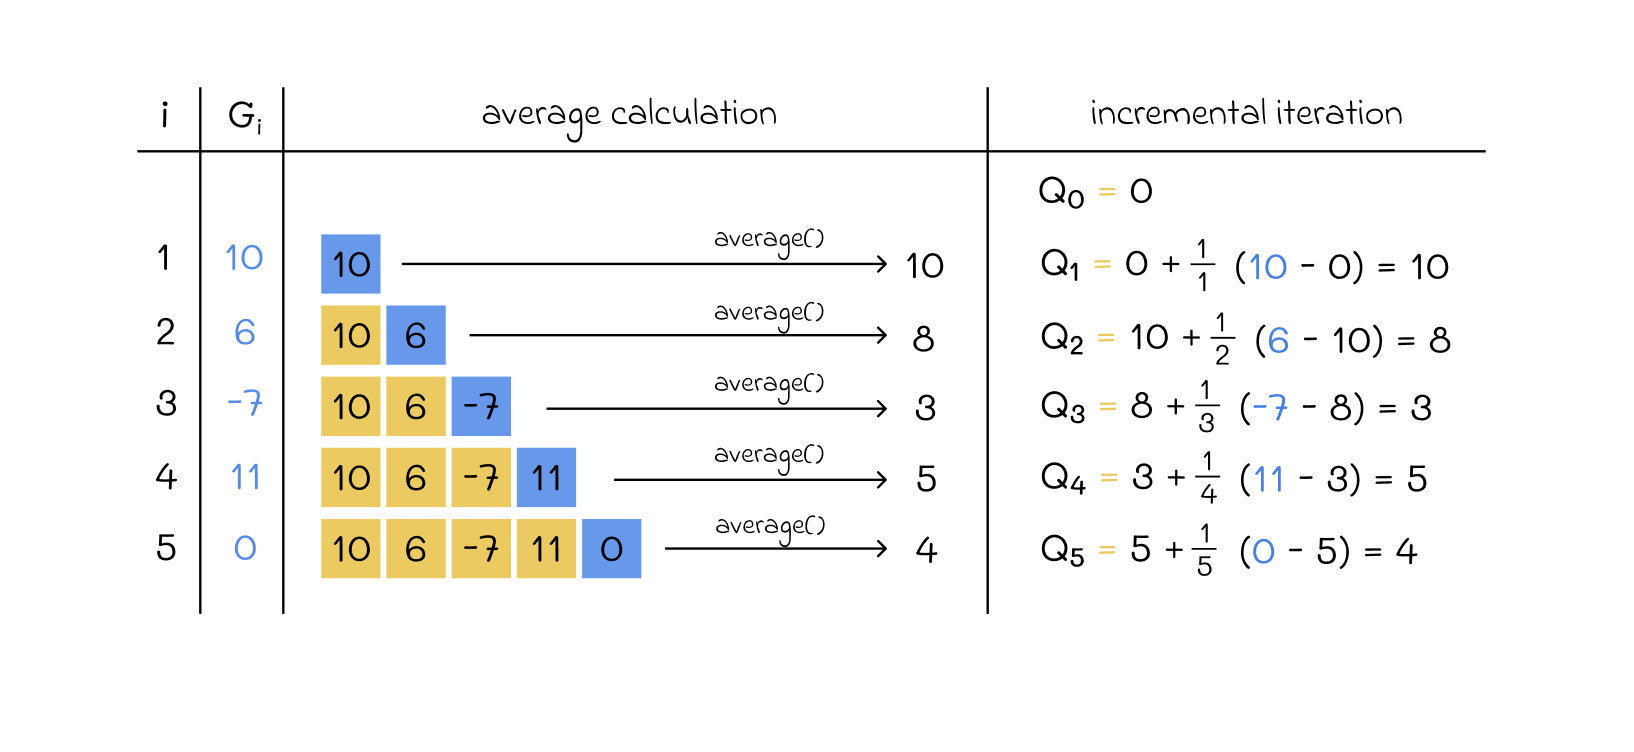

In [10]:
values = [10, 6, -7, 11, 0]
incremental_average = IncrementalAverage(value=0)
for value in values:
    print(f"The number {value} is added.")
    incremental_average.add(value)
    print(f"The incremental average is: {incremental_average.value:.2f}.\n")

The number 10 is added.
The incremental average is: 10.00.

The number 6 is added.
The incremental average is: 8.00.

The number -7 is added.
The incremental average is: 3.00.

The number 11 is added.
The incremental average is: 5.00.

The number 0 is added.
The incremental average is: 4.00.



## Player and Dealer classes
The Player and Dealer classes will have a lot of things in common, that is why it is logical to create a parent class for them. Let us call this class `Participant`.
* The `policy` will return an action (either *"Hit"* or *"Stick"*) of the participant depending on a given state.
* The `score` field will store the current score of a participant.
* The `cards` list will store the participant's cards.
* The `usable_ace` will indicate if the participant has an ace that can be counted as 11 without going busted.

The `take_card()` method samples a random card and updates the three fields mentioned above depending on the value of that card.

In [11]:
class Participant:

    CARDS = {
        **{value: value for value in range(2, 11)},
        'J': 10,
        'Q': 10,
        'K': 10,
        'A': 11
    }

    def __init__(self, name: str, policy: 'Policy'):
        self.name = name
        self.policy = policy
        self.cards = []
        self.score = 0
        self.usable_ace = False

    def take_card(self):
        card_name = random.sample(list(self.CARDS.keys()), 1)[0]
        self.cards.append(card_name)
        if card_name == 'A':
            if self.score <= 10:
                self.usable_ace = True
                self.score += 11
            else:
                self.score += 1
        else:
            self.score += self.CARDS[card_name]
        if self.score > 21 and self.usable_ace:
            self.score -= 10
            self.usable_ace = False

    def action(self, state: 'State') -> str:
        return self.policy(state)

    def __repr__(self) -> str:
        return f"{self.__name__} {self.name}. {self.policy} Cards: {self.cards}. Usable ace: {self.usable_ace}. Score: {self.score}. "

The initialization of the `Player` and `Dealer` classes is very similar. At the beginning of the game, the `Player` draws two cards, and the `Dealer` reveals its single card face up.

In [12]:
class Player(Participant):

    def __init__(self, name: str, policy: 'Policy'):
        super().__init__(name, policy)
        self.take_card()
        self.take_card()

In [13]:
class Dealer(Participant):

    def __init__(self, name: str, policy: 'Policy'):
        super().__init__(name, policy)
        self.take_card()

## State
To analyze episodes, we will have to store game states. Every single game state is a combination of the player's score, the dealer's first card and a boolean variable indicating whether a player has a usable ace or not. These three variables contain all the possible game factors the player needs to take into account to make a decision. Storing states when the dealer has more than 1 card is not important to us, since the player in that stage of the game does not take decisions anymore (it is up to the dealer to take cards).

**Note**. For simplicity, we are not going to consider trivial game states, in particular, when the player has less than 12 points. In this case, it is always optimal for the player to hit to improve their score (they cannot pass over 21).

In [14]:
class State:

    def __init__(self, player: Player, dealer: Dealer, action: str=None):
        
        self.player_name = player.name
        self.player_score = player.score
        self.player_usable_ace = player.usable_ace

        self.action = action # this field will be used for Q-function estimation later

        self.dealer_name = dealer.name
        self.dealer_score = dealer.score
        self.dealer_usable_ace = dealer.usable_ace # it is not part of the state we have defined but we will store it for convenience

    def __repr__(self) -> str:
        action_str = '' if self.action is None else f', action={self.action}'
        return (
            f"{self.player_name}(score={self.player_score}, ace={self.player_usable_ace}{action_str}), " +
            f"{self.dealer_name}(score={self.dealer_score}, ace={self.dealer_usable_ace})."
        )

## Policy
To samples games in different settings, let us create several types of policies. First of all, we will create the abstract `Policy` class. Every inherited policy will have to implement the `__call__()` method.

In [15]:
class Policy:

    def __init__(self, description: str):
        self.description = description

    def __call__(self, state: State) -> str:
        raise NotImplementedError(f"The __call__() method of {self.name} policy is not implemented")

    def __repr__(self) -> str:
        return f"Policy: {self.description}."

According to the Blackjack rules, the `Dealer` always have the same deterministic policy:
* If the dealer's score $\lt$ 17, then the dealer hits.
* If the dealer's score $\ge$ 17, then the dealer sticks.

In [16]:
class DealerPolicy(Policy):

    def __call__(self, state: State) -> str:
        return "HIT" if state.dealer_score < 17 else "STICK"

The `StickOn20Policy` will be used by the `Player`:
* If the player's score $\lt$ 20, then the player hits.
* If the player's score $\ge$ 20, then the player sticks.

In [17]:
class StickOn20Policy(Policy):

    def __call__(self, state: State) -> str:
        return "HIT" if state.player_score < 20 else "STICK"

The `RandomPolicy` will sample actions based on a provided probability distribution. By default, the distribution is uniform: $p(hit) = p(stick) = 0.5$.

In [32]:
class StochasticPolicy(Policy):

    def __init__(self, description: str, action_distribution: dict=None):
        super().__init__(description)
        self.action_distribution = {"HIT": 0.5, "STICK": 0.5} if action_distribution is None else action_distribution

    def __call__(self, state: State) -> str:
        return sample_key_from_dict(self.action_distribution)

The `EpsilonGreedyPolicy` will implement the $\epsilon$-greedy policy (the $\epsilon$ parameter is passed into the constructor). In the `__call__()` method we will invoke another method `_transform_to_epsilon_greedy()`to transform a given greedy distribution to $\epsilon$-greedy.

In [19]:
class EpsilonGreedyPolicy(Policy):

    def __init__(self, description: str, eps: float=0):
        super().__init__(description)
        self.eps = eps
        self.mapping = self.function = {
            (player_score, player_usable_ace, dealer_score): {action: 0.5 for action in ["HIT", "STICK"]}
            for player_score in range(12, 22)
            for player_usable_ace in [True, False]
            for dealer_score in range(1, 11)
        }

    def _transform_to_epsilon_greedy(self, action_distribution: dict) -> dict:
        action_argmax = max(action_distribution, key=action_distribution.get)
        action_argmin = min(action_distribution, key=action_distribution.get)
        return {
            action_argmax: 1 - self.eps / 2,
            action_argmin: self.eps / 2
        }

    def __call__(self, state: State) -> str:
        dealer_score = 1 if state.dealer_score == 11 else state.dealer_score
        if (state.player_score, state.player_usable_ace, dealer_score) in self.mapping:
            action_distribution = self.mapping[(state.player_score, state.player_usable_ace, dealer_score)]
        else:
            action_distribution = {"STICK": 0, "HIT": 1}
        return sample_key_from_dict(self._transform_to_epsilon_greedy(action_distribution))

## Game
Let us create the `Game` class that will simulate a single game. To be able to analyze game episodes, we will keep the list `states` containing all states of a game where the player has to make a decision. In other words, we will add a state of the game if the player's score $\ge$ 12 and the dealer has only 1 card.

In [20]:
class Game:

    RETURNS = {
        "WIN": 1,
        "DRAW": 0,
        "LOSE": -1
    }

    def __init__(self, player: Player, dealer: Dealer):
        self.player = player
        self.dealer = dealer
        self.states = []

    def play(self) -> float:
        player_sticks = False
        while True:
            state = State(self.player, self.dealer)
            state.action = "STICK" if player_sticks or self.player.action(state) == "STICK" else "HIT"
            if state.action == "STICK":
                player_sticks = True
            if self.player.score >= 12 and len(self.dealer.cards) == 1:
                self.states.append(state)
            if self.player.score <= 21 and not player_sticks:
                self.player.take_card()
                if self.player.score > 21:
                    return self.RETURNS["LOSE"]
            elif self.player.score <= 21 and player_sticks:
                if self.dealer.action(state) == "STICK":
                    if self.player.score == self.dealer.score:
                        return self.RETURNS["DRAW"]
                    return self.RETURNS["WIN"] if self.player.score > self.dealer.score else self.RETURNS["LOSE"]
                elif self.dealer.action(state) == "HIT":
                    self.dealer.take_card()
                    if self.dealer.score > 21:
                        return self.RETURNS["WIN"]

Finally, to be able to analyze game states, we will create the abstract `ValueFunction` class. The derived classes will have to implement functionality for the `function` field which will store the mapping between game states and their value functions.
* The `get()` method returns the value function for a given state.
* The `_get_key()` method should convert passed states to the dictionary format for the `self.function` field.
* The `update()` method modifies the value function for the passed states of an episode for which the return `G` is known.
* The `get_results()` method returns a formatted DataFrame with columns `[player_score, player_usable_ace, dealer_score, value]` for all game states.

In [21]:
class ValueFunction:

    def __init__(self, v0: float=0, alpha: float=None):
        raise NotImplementedError('The __init__() method is not implemented.')

    def get(self, state) -> float:
        return self.function[self._get_key(state)]

    def _get_key(self, state) -> tuple:
        raise NotImplementedError('The _get_key() method is not implemented.')

    def update(self, states, G):
        if isinstance(states, State):
            states = [states]
        for state in states:
            if state.dealer_usable_ace:
                state.dealer_score -= 10 # for convienience, we will count an ace as a single point (instead of 11)
                if state.dealer_score != 1: # the dealer has other cards than an ace and we are not interested in such states
                    continue
            key = self._get_key(state)
            if key in self.function:
                self.function[key].add(G)

    def get_results(self) -> pd.DataFrame:
        raise NotImplementedError('The get_results() method is not implemented.')

## V-function
We will write code to estimate the V-function under a given player's policy. To do that, we initialize the V-function in the constructor by assigning all v-values to 0. The implementation of other methods is straightforward.

In [22]:
class VFunction(ValueFunction):

    def __init__(self, v0: float=0, alpha: float=None):
        self.function = {
            (player_score, player_usable_ace, dealer_score): IncrementalAverage(value=v0, alpha=alpha)
            for player_score in range(12, 22)
            for player_usable_ace in [True, False]
            for dealer_score in range(1, 11)
        }

    def _get_key(self, state):
        return (state.player_score, state.player_usable_ace, state.dealer_score)

    def get_results(self):
        values = [{
            'player_score': key[0],
            'player_usable_ace': key[1],
            'dealer_score': key[2],
            'value': value.value
        } for key, value in self.function.items()]
        return pd.DataFrame(values)

Let us sample five millions episodes and average the received returns for all states. In our example, for the player, we will use the `StickOn20Policy`.

In [28]:
player_policy = StickOn20Policy('The player sticks on 20')
dealer_policy = DealerPolicy('The dealer sticks on 17')

In [25]:
V_estimator = VFunction()
for i in tqdm(range(5_000_000)):
    player = Player('player', policy=player_policy)
    dealer = Dealer('dealer', policy=dealer_policy)
    game = Game(player, dealer)
    G = game.play()
    V_estimator.update(game.states, G)
V = V_estimator.get_results()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5000000/5000000 [00:36<00:00, 138658.43it/s]


Now we can plot the estimates. Since we have three variables, it would be easier to visualise the results in the form of two heatmaps where horizontal and vertical axes represent the player's and the dealer's scores respectively and each heatmap corresponds to a situation whether the player has a usable ace or not.

**Note**. The value of 1 on the vertical axis will correspond to the event when the dealer's first card is ace.

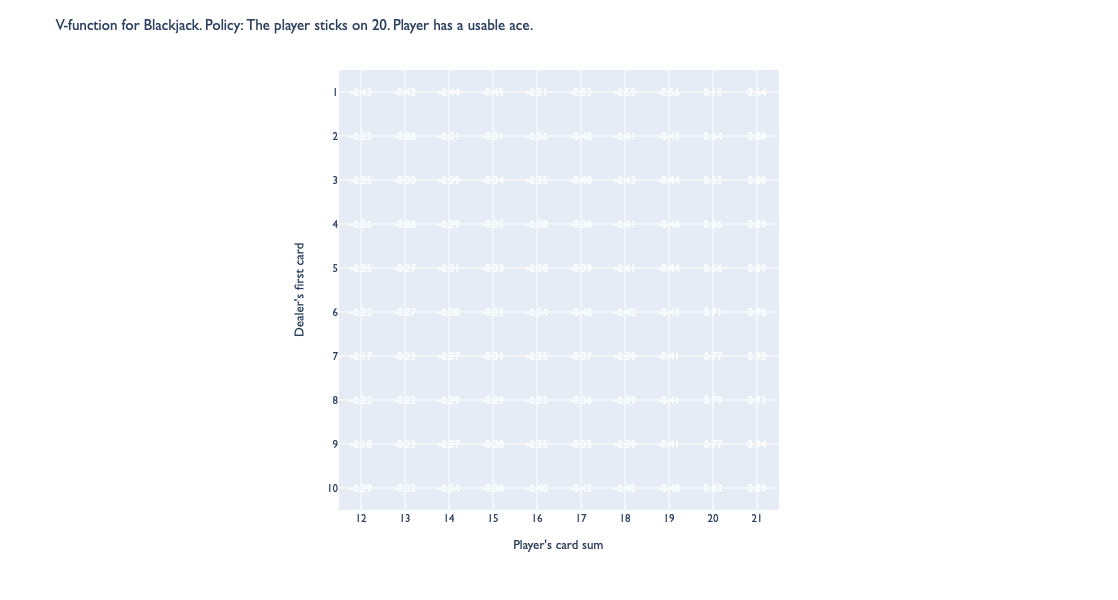

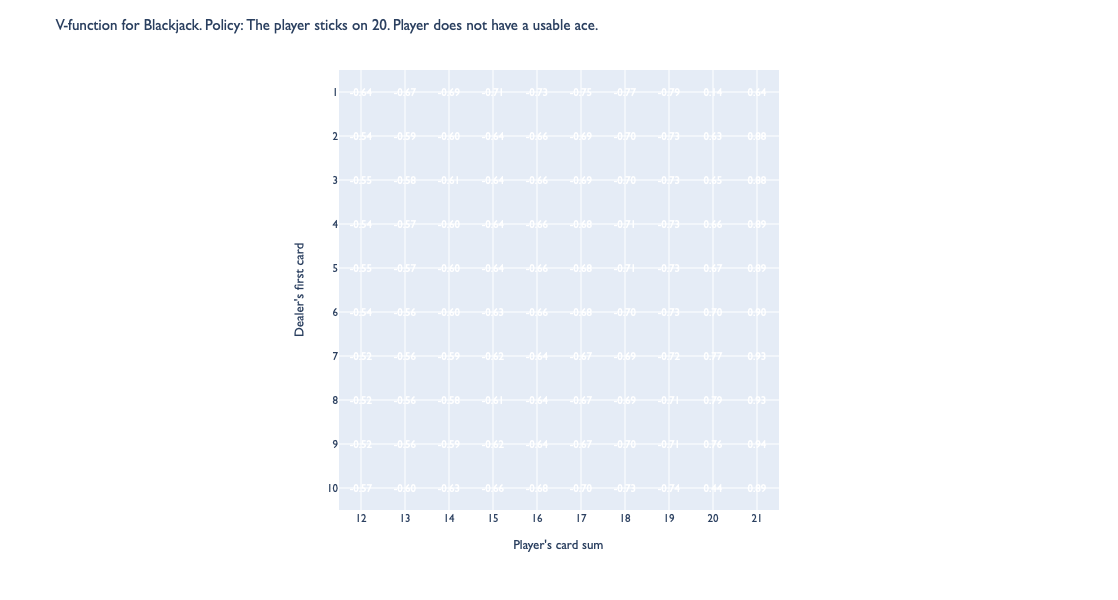

In [29]:
player_usable_ace_options = [True, False]
for player_usable_ace in player_usable_ace_options:
    df = V[V['player_usable_ace'] == player_usable_ace].pivot(index='player_score', columns='dealer_score')['value'].T
    plot(
        df,
        title=f'V-function for Blackjack. {player_policy} Player {"has" if player_usable_ace else "does not have"} a usable ace.',
        colorscale='bluered_r'
    )

We can make several useful observations from the obtained V-table:
* The overall policy of sticking only after reaching 20 performs poorly. The only two situations when a player has an advantange occur only when his score is either 20 or 21. If a player has 18, for example, and takes another card, it is very likely that he will overpass 21 (by getting any card with the value of 4 or greater) and lose the game.
* The color structure of both heatmaps is very similar. However, the presence of a usable ace gives the player a "second chance" if their score exceeds 21. Therefore, the corresponding v-values for cases with usable aces are higher than those without it.
* The obtained v-values for games with a usable ace are less precise. This is explained by the fact that these cases occur less frequently in Blackjack. A possible solution would consist of generating more episodes.
* For information, the last column corresponding to the player hitting 21 points does not contain values of 1. Even if a player gets 21, there is a small probability that the dealer will also get exactly 21. In this case, the episode's return if 0 and the overall average is shifted slightly lower than 1.

Theoretically we could have used dynamic programming algorithms for estimation of blackjack states but it would be much harder. For instance, imagine that the player has 13 points. To calculate the V-value for that state, we would need all transition probabilities from 14 to 21 points which are extremely hard to estimate using probability formulas, since there are too many possible game combinations.

## Q-function
One of the main advantages of Monte Carlo methods is the fact that they can be used for estimation of Q-functions without knowledge of the environment's dynamics. All we have to do is to reformulate the problem by considering all possible *(state, action)* pairs as states. As a consequence, the algorithm becomes very similar to the one used for estimation of V-functions.

To implement this idea in code, we only have to add the `action` variable to our mapping function:

In [48]:
class QFunction(ValueFunction):

    def __init__(self, q0: float=0, alpha: float=None):
        self.function = {
            (player_score, player_usable_ace, dealer_score, action): IncrementalAverage(value=q0, alpha=alpha)
            for player_score in range(12, 22)
            for player_usable_ace in [True, False]
            for dealer_score in range(1, 11)
            for action in ["HIT", "STICK"] # possible actions are considered in game states
        }

    def _get_key(self, state):
        # every state is now a tuple of 4 variables
        return (state.player_score, state.player_usable_ace, state.dealer_score, state.action)

    def get_results(self):
        values = [{
            'player_score': key[0],
            'player_usable_ace': key[1],
            'dealer_score': key[2],
            'action': key[3],
            'value': value.value
        } for key, value in self.function.items()]
        return pd.DataFrame(values)

In this example, we are going to use the `StochasticPolicy` where the player's hit and stick actions are chosen equiprobably ($p=0.5$) at random.

In [49]:
action_distribution = {"HIT": 0.5, "STICK": 0.5}
player_policy = StochasticPolicy(
    description=f'p(hit) = {action_distribution["HIT"]}, p(stick) = {action_distribution["STICK"]}',
    action_distribution=action_distribution
)
dealer_policy = DealerPolicy('The dealer sticks on 17')

In [50]:
Q_estimator = QFunction()
cards = []
for i in tqdm(range(5_000_000)):
    player = Player('player', policy=player_policy)
    dealer = Dealer('dealer', policy=dealer_policy)
    game = Game(player, dealer)
    G = game.play()
    Q_estimator.update(game.states, G)
Q = Q_estimator.get_results()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5000000/5000000 [00:38<00:00, 131301.67it/s]


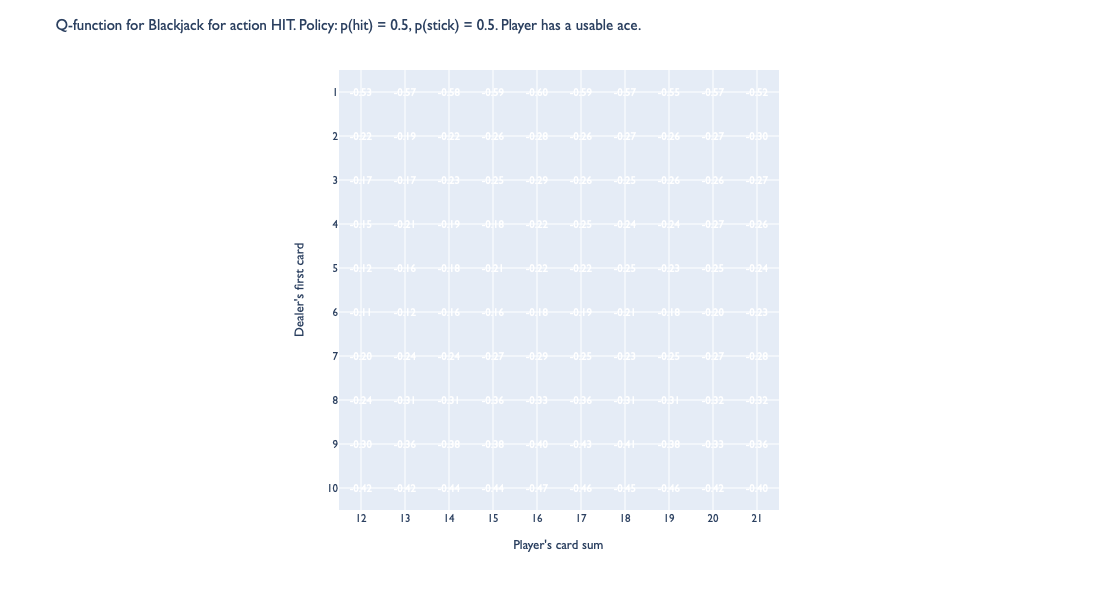

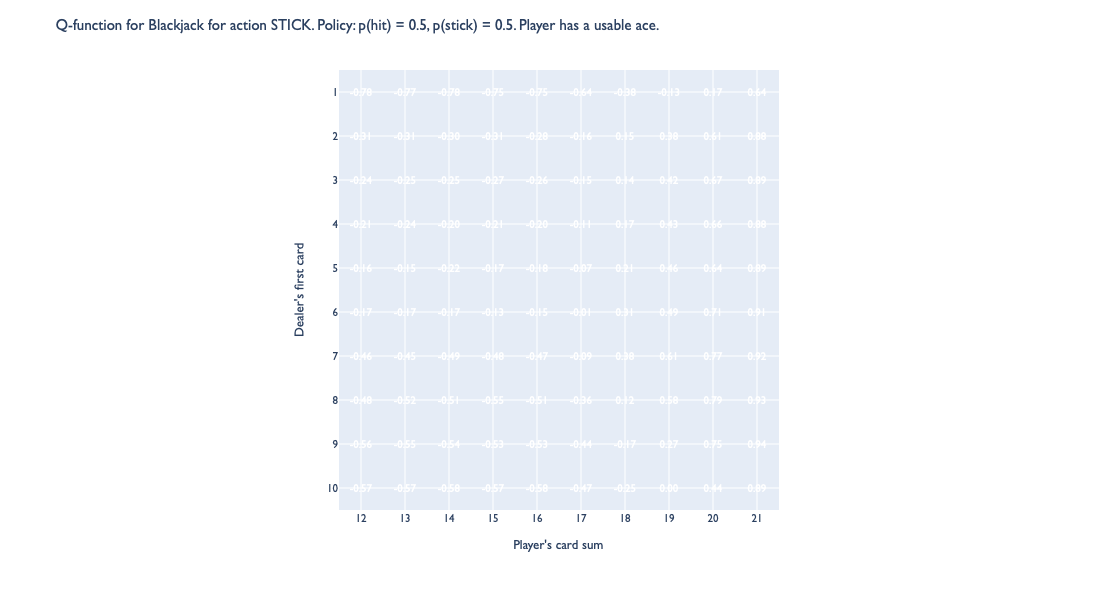

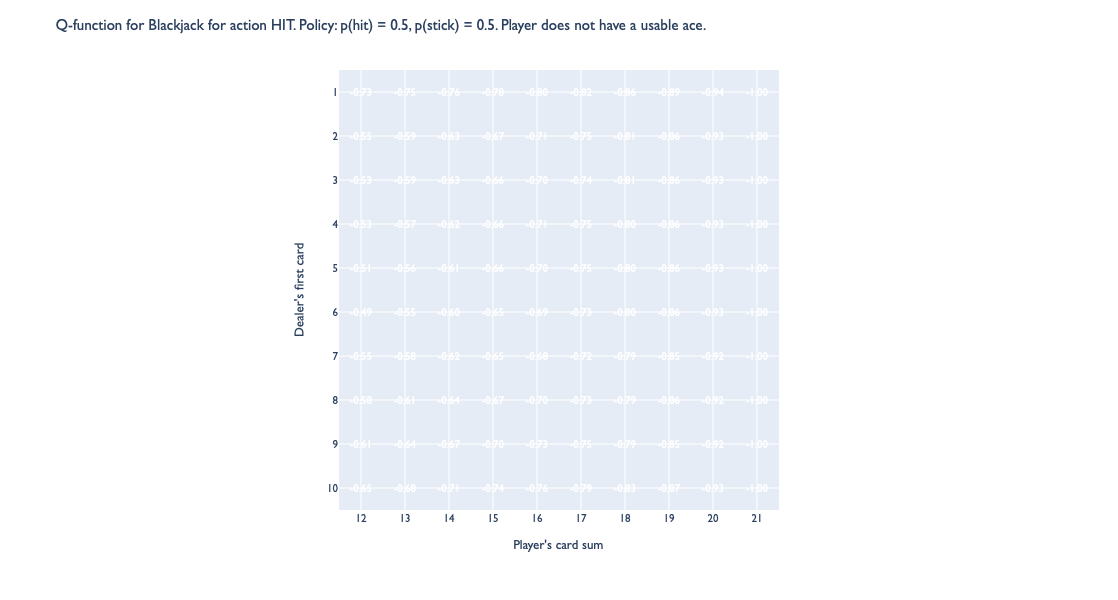

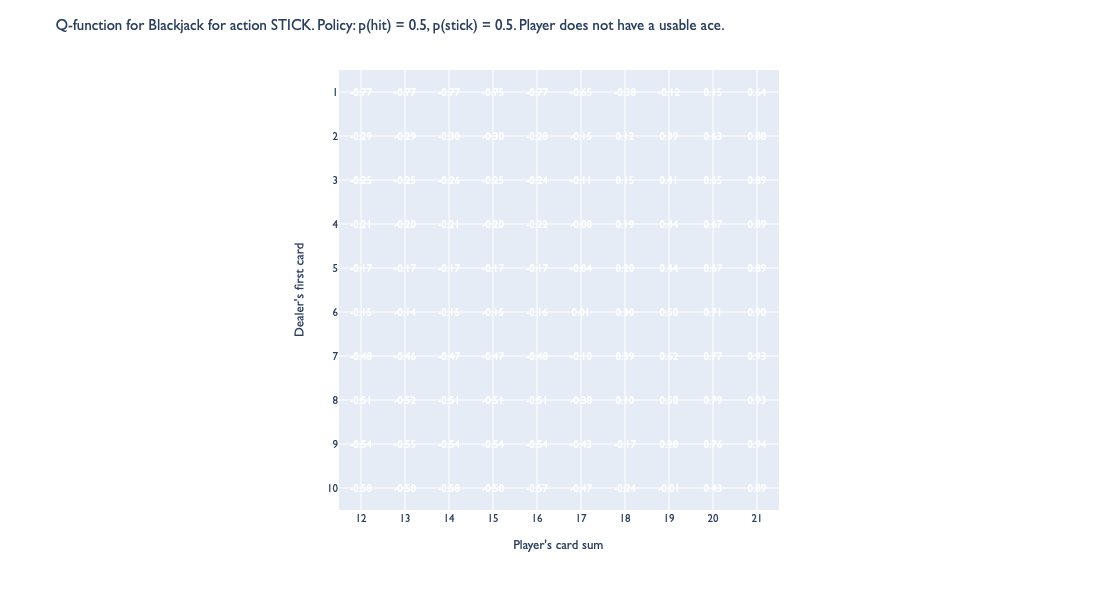

In [51]:
player_usable_ace_options = [True, False]
action_options = ["HIT", "STICK"]
for player_usable_ace, action in itertools.product(player_usable_ace_options, action_options):
    df = Q[(Q['player_usable_ace'] == player_usable_ace) & (Q['action'] == action)].pivot(index='player_score', columns='dealer_score')['value'].T
    plot(
        df,
        title=f'Q-function for Blackjack for action {action}. {player_policy} Player {"has" if player_usable_ace else "does not have"} a usable ace.',
        colorscale='bluered_r'
    )

* As in the previous scenario, diagrams with and without a usable ace are similar to each other except for the fact that the usable ace gives a higher chance for the player to win for every state.
* The diagram with the overall lowest q-values is for the action hit in the case without a usable ace. The two factors contributing to it are the facts that, firstly, by hitting, the player already faces the risk of going busted, and, secondly, there is a 50% chance (according to our policy) that the player will hit again which significantly increases the chances of losing a game. As a consequence, the last column for 21 player points consists of all -1, since the player is guaranteed to lose the game by hitting in all of these situations.

# Monte Carlo Control
For finding the optimal policy, we are going to use an $\epsilon$-greedy policy. The two very important hyperparameters we need to define are:
* $\epsilon$ - the probability that an action is chosen at random during the policy improvement step;
* $\alpha$ - the scaling parameter in incremental average for Q-function estimation.

In [39]:
eps = 0.1
alpha = 0.005

In [40]:
player_policy = EpsilonGreedyPolicy(f'Epsilon-greedy policy (eps={eps}).', eps=eps)
dealer_policy = DealerPolicy('The dealer sticks on 17')

In [42]:
Q_estimator = QFunction(q0=0, alpha=alpha)
for i in tqdm(range(5_000_000)):
    player = Player('player', policy=player_policy)
    dealer = Dealer('dealer', policy=dealer_policy)

    # episode sampling
    game = Game(player, dealer)
    G = game.play()

    # policy evaluation
    Q_estimator.update(game.states, G)

    # policy improvement
    for state in game.states:
        q = {
            action: Q_estimator.function[(state.player_score, state.player_usable_ace, state.dealer_score, action)].value
            for action in ["HIT", "STICK"]
        }
        hit_is_better = q["HIT"] > q["STICK"]
        dealer_score = 1 if state.dealer_score == 11 else state.dealer_score
        player_policy.mapping[(state.player_score, state.player_usable_ace, dealer_score)] = {
            "HIT": int(hit_is_better),
            "STICK": int(not hit_is_better)
        }
Q = Q_estimator.get_results()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000000/5000000 [00:50<00:00, 98466.00it/s]


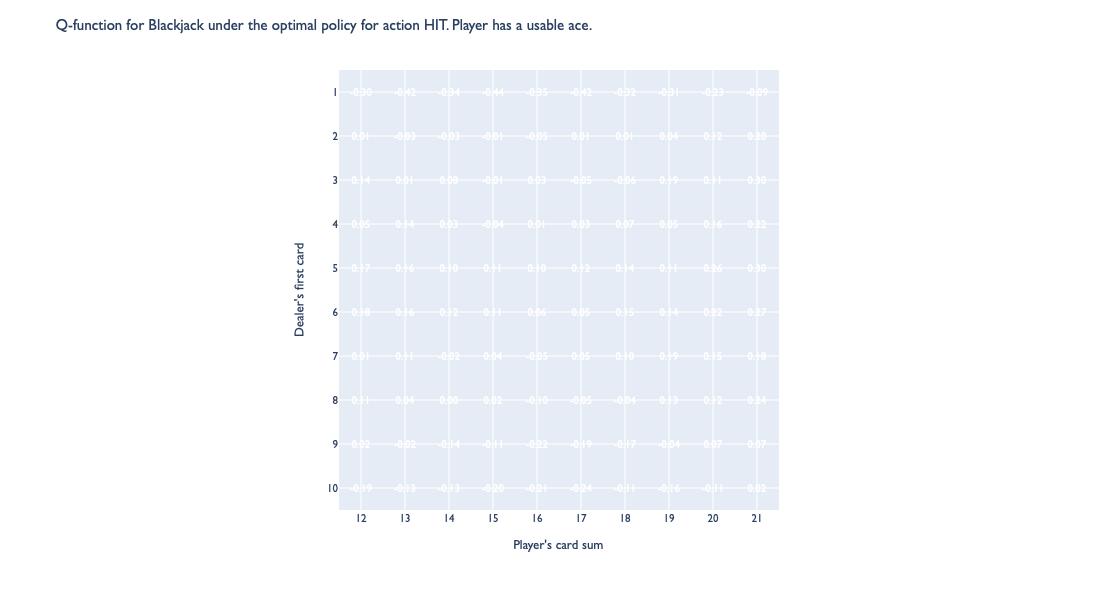

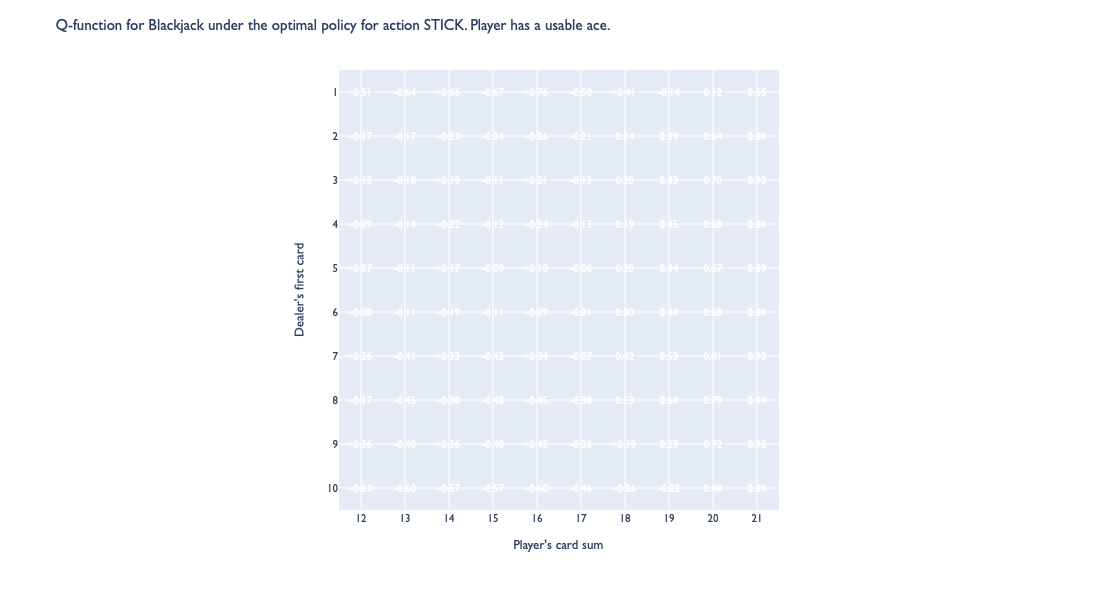

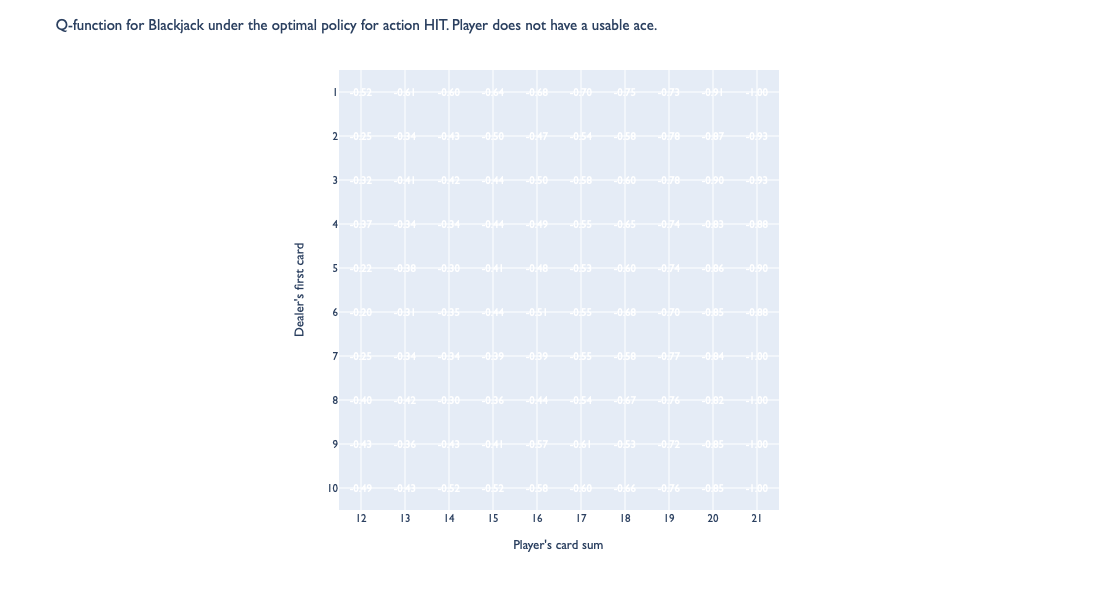

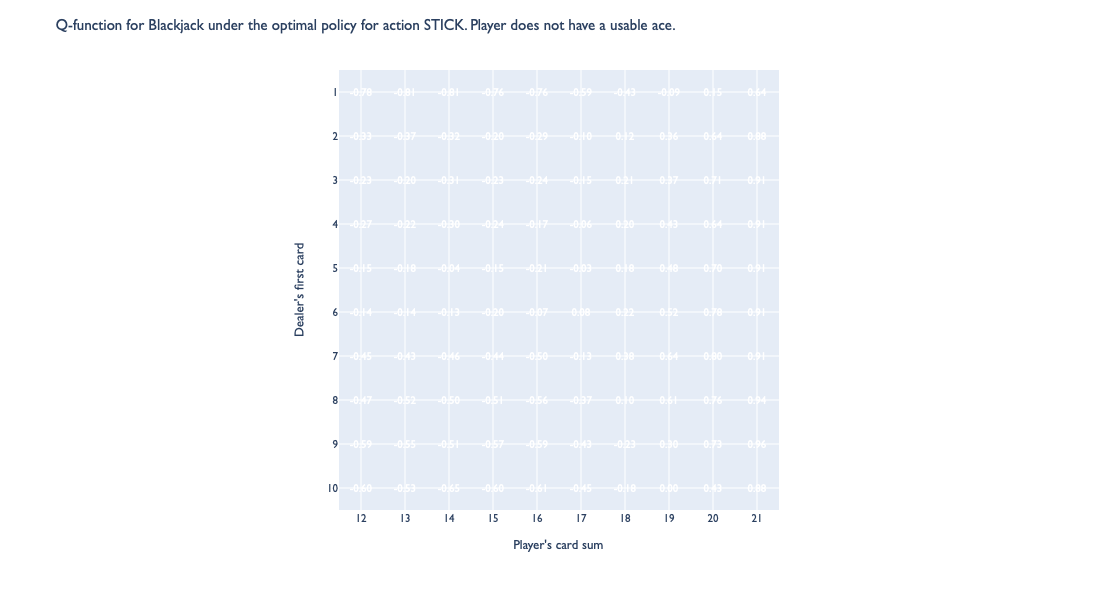

In [43]:
player_usable_ace_options = [True, False]
action_options = ["HIT", "STICK"]
for player_usable_ace, action in itertools.product(player_usable_ace_options, action_options):
    df = Q[(Q['player_usable_ace'] == player_usable_ace) & (Q['action'] == action)].pivot(index='player_score', columns='dealer_score')['value'].T
    plot(
        df,
        title=f'Q-function for Blackjack under the optimal policy for action {action}. Player {"has" if player_usable_ace else "does not have"} a usable ace.',
        colorscale='bluered_r'
    )

We have constructed the Q-function under the optimal policy. In reality, it might considerably differ from the real Q-function.

Let us take the q-value equal to -0.88 for the case when the player decides to hit having 21 points without a usable ace when the dealer has 6 points. It is obvious that the player will always lose in this situation. So why is the q-value not equal to -1 in this case? Here are the main two reasons:

* In the beginning of training, the algorithm does not know well which actions are better for certain states and picks them almost randomly. It might turn out that at some point, the difference of q-values between two actions becomes considerable. Therefore, during the policy improvement step, the algorithm will always greedily choose the action with the maximal reward. As a result, other actions with lower returns will never be sampled again and their true q-values will not be calculated adequately.
* We have set the α to 0.005 (explained in the section "Constant-α MC" below) which means that the algorithm needs some time to converge to the right answer. If we used more than $5 \cdot 10^6$ iterations or used another value for α, than the estimated value could have been a little closer to -1.

If we look at the same state with the only difference of the dealer having 7 points, then the q-value is equal to -1 which is actually true. So as we can see, the algorithm converges differently for similar states due to its stochastic nature.

To directly obtain the optimal policy, we only need compare returns for hit and stick actions in the same states and choose those whose q-values are greater.

In [45]:
actions = [{
    'player_score': key[0],
    'player_usable_ace': key[1],
    'dealer_score': key[2],
    'value': 1 if action['HIT'] == 1 else -1
} for key, action in player_policy.mapping.items()]
optimal_policy = pd.DataFrame(actions)

We will plot the optimal policy in the form of two binary heatmaps where red cells will correspond to hit actions and blue cells will relate to stick actions.

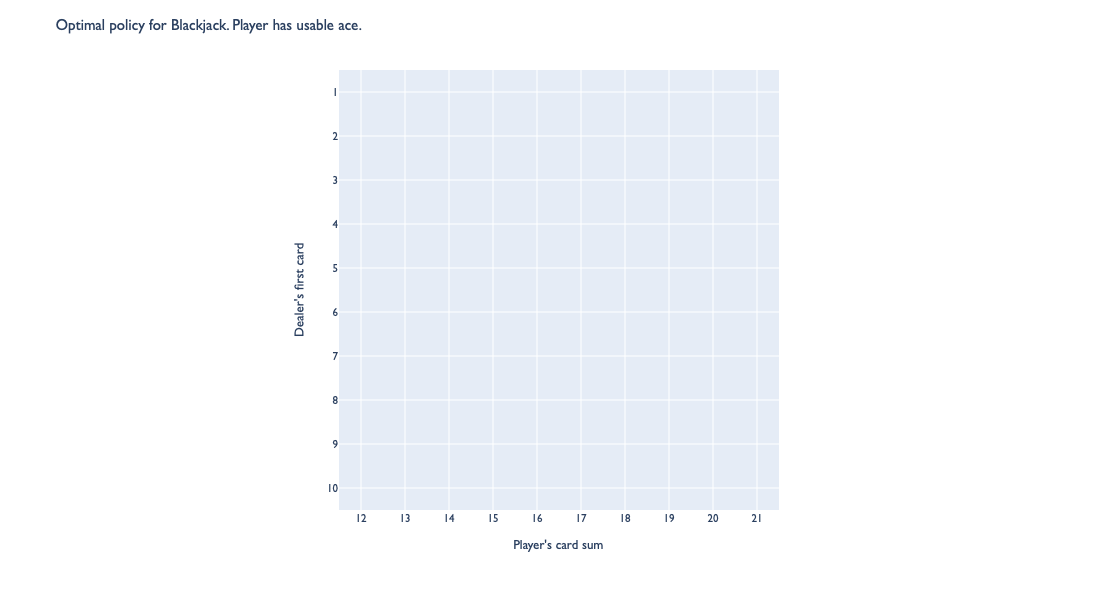

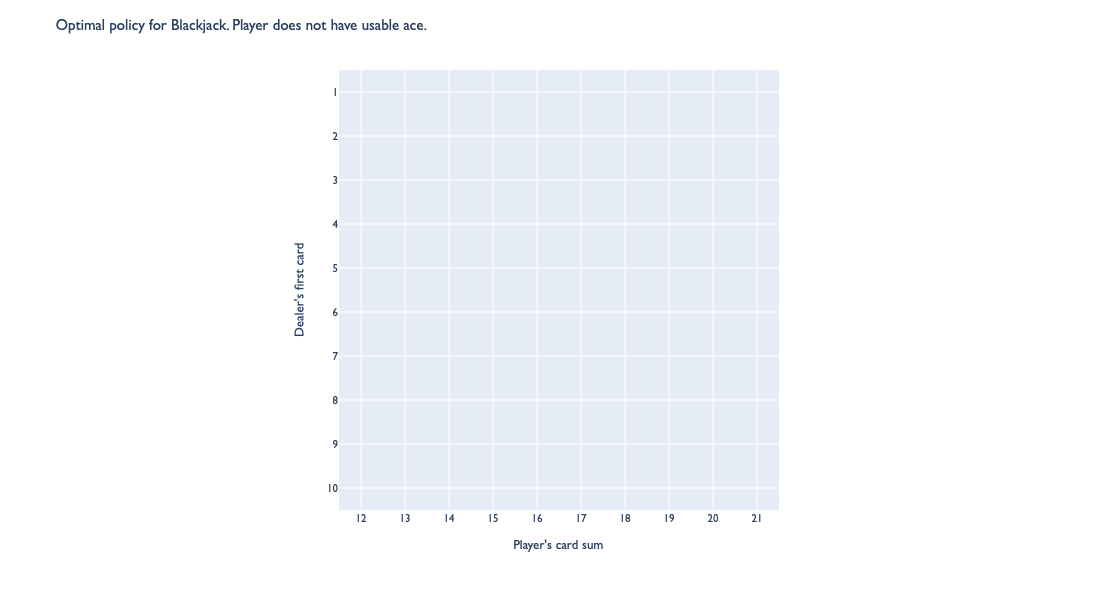

In [46]:
player_usable_ace_options = [True, False]
for player_usable_ace in player_usable_ace_options:
    df = optimal_policy[optimal_policy['player_usable_ace'] == player_usable_ace].pivot(index='player_score', columns='dealer_score')['value'].T
    plot(
        df,
        title=f'Optimal policy for Blackjack. Player {"has" if player_usable_ace else "does not have"} a usable ace.',
        colorscale=[[0, '#4766f4'], [1, '#ff5282']],
        show_annotations=False,
        show_colorscale=False
    )

It turns out that the obtained blackjack policy is very close to the real optimal strategy! This fact indicates that we have successfully implemented the Monte Carlo algorithm and have chosen good hyperparameter values. 

As an additional exercise, one can experiment with $\epsilon$ and $\alpha$ parameters to obtain and see how they affect the final result.